# BAKGRUND

#### BEHOV
* Redaktionen vill förstå när och hur läsare är som mest engagerade och aktiva digitalt.
* Det driver bland annat deras publiceringsmönster och konverteringsstrategi.
* Vill gärna få det nedbrutet på sektionsnivå så att det kan driva avdelningarnas individuella redaktionella strategi. 
* Dels vill man se absoluta tal, dels relativt en föregående period för att se om läsbeteenden har förändrats.

#### PROBLEM
* Vi tittar periodiskt på detta - ungefär två gånger om året. 
* Kräver ofta stor handpåläggning att hämta, bearbeta och visualisera datat - väldigt manuellt arbete.
* Metoden kan variera - ex. hur vi sållar ut outliers, justerar för inflation/deflation i jämförelsen mellan perioder.

#### LÖSNING 
* Gör en semi-automatisk notebook som spottar ut graferna vi vill ha genom en konsekvent metod. 
* Detta minskar det manuella arbetet och ökar flexibiliteten att möta mer spontana behov. 
* Det gör också att vi kan förbättra metoden över tid. 
* Förhoppningsvis kan detta dessutom användas av flera varumärken - och fler ögon kommer göra koden väsentligt bättre.
* Väldigt lättanpassat för data som finns i Reynolds.

#### OBS!
* Det finns säkerligen förbättringspotential i detta - all feedback uppskattas!
* Finns inte på Github just nu men kommer laddas upp. 

In [342]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import normalize
from datetime import datetime

# Special functions for this purpose
from functions import date_check, transform_weekday, normalise_weeks, detect_outlier, remove_outliers, standard_pivot, comparison_pivot, pivot_method, filter_params, heatmap

In [343]:
# PROBLEMS
    # Comparisons produce some unexpected (i.e. hard-to-believe) inflation numbers.
    # It would be nice to look at "qualitative" article pageviews only - that last longer than 10 seconds.
    
# TO DO    
    # Add timelines
    # Add purchases

# 1. SET-UP

#### What you need to decide prior to running the notebook:
* The date range you want to examine. 
* An older date range if you want to make a comparison.
* If you want to examine browsers or accounts.

In [344]:
# SELECT THE APPROPRIATE DATA WAREHOUSE
PROJECT = 'data-warehouse-dn'

# SELECT A TIME PERIOD TO ANALYSE. (MAKE SURE IT IS MADE UP OF FULL WEEKS - USE THE FUNCTION BELOW). 
FROM_DATE = '2020-11-08'
TO_DATE = '2021-02-13' # 01-10

# SELECT A COMPARISON TIME PERIOD (PREFERABLY WITH COMPARABLE # OF WEEKS - ALTHOUGH WE WILL NORMALISE BY WEEK LATER).
FROM_DATE_COMP = '2019-11-08' # 08-03
TO_DATE_COMP = '2020-02-13' # 11-08

# SELECT UNIT OF ANALYSIS: EITHER BROWSERS OR ACCOUNTS.
ID = 'client_id' # user_id, client_id

# (We will use this later.)
dates = {
    'from_date': FROM_DATE,
    'to_date': TO_DATE,
    'from_date_comp': FROM_DATE_COMP,
    'to_date_comp': TO_DATE_COMP
}

#### Make sure there is an equal number of "day types" (e.g. Monday, Tuesday) in each date range - i.e. that you have selected "complete weeks." The code block below will check this for you.

In [345]:
print("CURRENT DATE RANGE")
date_check(from_date=FROM_DATE, to_date=TO_DATE) 
    
print("\nCOMPARISON DATE RANGE")
date_check(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP)

CURRENT DATE RANGE
Approved date range. Equal number of days of week.
Number of days: 98
Number of weeks: 14

COMPARISON DATE RANGE
Approved date range. Equal number of days of week.
Number of days: 98
Number of weeks: 14


# 2. IMPORT DATA

## 2.1 READING (PAGEVIEWS, MINUTES SPENT, USERS)

In [346]:
# SELECT GROUPING VARIABLE
GROUPING = 'data_source' # Total, section, device_category, login_status, referrer_category, data_source

# EXTRA: SELECT SECTION FILTER
    # If you use only one section, add '' symbols to the expression... 
SECTIONS = '("Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan")' # e.g. '("Kultur")' OR ("Nyheter", "Världen", "Sverige", "Ekonomi", "Kultur", "Sport", "STHLM", "Gbg", "Ledare", "DN Debatt", "Insidan")

In [347]:
def reading_query_text(from_date, to_date, grouping=GROUPING):
    
    if grouping == 'Total':
        GROUPING_QUERY_INPUT = '"Total" AS Total'
    else:
        GROUPING_QUERY_INPUT = GROUPING

    query = (f'''
    
                WITH active_duration AS (
                  SELECT
                    pageview_id,
                    SUM(SAFE_CAST(label AS INT64)) AS sum_time
                  FROM `data-warehouse-dn.reynolds.event` 
                  WHERE 1=1
                    AND action = 'Active Duration'
                    AND date BETWEEN "{from_date}" AND "{to_date}"
                  GROUP BY 1
                )

                SELECT 

                  # Groupings
                  pv.date,
                  EXTRACT(DAYOFWEEK FROM pv.date) AS weekday,
                  EXTRACT(HOUR FROM pv.timestamp AT TIME ZONE "Europe/Stockholm") AS hour, 
                  {GROUPING_QUERY_INPUT},

                  # KPIs
                  COUNT(DISTINCT pv.pageview_id) AS n_pageviews,
                  COUNT(DISTINCT
                    CASE WHEN LOWER(page_type) IN ("start page", "article list page") 
                    THEN pv.pageview_id ELSE NULL END) AS n_flak_pageviews, 
                  COUNT(DISTINCT
                    CASE WHEN LOWER(page_type) IN ("articlepage", "article page") 
                    THEN pv.pageview_id ELSE NULL END) AS n_article_pageviews, 
                  COUNT(DISTINCT
                    CASE WHEN ev.action = "Active Duration" AND LOWER(page_type) IN ("articlepage", "article page") AND SAFE_CAST(ev.label AS INT64) > 10000
                    THEN pv.pageview_id ELSE NULL END) AS n_real_article_pageviews,
                  COUNT(DISTINCT
                    CASE WHEN LOWER(page_type) IN ("articlepage", "article page") AND sum_time > 180000
                    THEN pv.pageview_id ELSE NULL END) AS n_longreads,
                  ROUND(SUM(DISTINCT
                    CASE WHEN ev.action = "Active Duration" 
                    THEN SAFE_CAST(ev.label AS INT64) ELSE NULL END
                    ) / 1000 / 60, 1) AS n_active_minutes,
                  ROUND(SUM(DISTINCT
                    CASE WHEN ev.action = "Active Duration" AND LOWER(page_type) IN ("articlepage", "article page") 
                    THEN SAFE_CAST(ev.label AS INT64) ELSE NULL END
                    ) / 1000 / 60, 1) AS n_active_article_minutes,
                  COUNT(DISTINCT pv.user_id) AS n_accounts,
                  COUNT(DISTINCT pv.client_id) AS n_browsers

                FROM `{PROJECT}.reynolds.pageview` pv 
                JOIN `{PROJECT}.reynolds.event` ev ON ev.date = pv.date AND ev.pageview_id = pv.pageview_id
                LEFT JOIN active_duration ad ON pv.pageview_id = ad.pageview_id

                WHERE 1=1
                  AND pv.date BETWEEN "{from_date}" AND "{to_date}"
                  AND sub_brand = "DNSE"
                  AND {ID} NOT IN ("", "N/A", "(not set)")
                  AND {ID} IS NOT NULL
                  AND section IN {SECTIONS}
                  AND content_id NOT LIKE "%dn.adhoc.%"
                  AND content_id NOT LIKE "%dn.ctf%"
                GROUP BY 1,2,3,4

            '''
            )
    
    return(query)

In [348]:
df = (
    pd.read_gbq(reading_query_text(from_date=FROM_DATE, to_date=TO_DATE, grouping='Total'), project_id=PROJECT)
)

Downloading: 100%|██████████| 2352/2352 [00:00<00:00, 3027.90rows/s]


In [146]:
df = remove_outliers(data=df, partition=GROUPING)

# Aggregate the KPIs based on mean aggregation - since we want the average of each KPI per WEEK
kpis = {'n_pageviews':'mean',
        'n_flak_pageviews':'mean',
        'n_article_pageviews':'mean',
        'n_real_article_pageviews':'mean',
        'n_longreads':'mean',
        'n_active_minutes':'mean',
        'n_active_article_minutes':'mean',
        'n_browsers':'mean',
        'n_accounts':'mean'}

# Eliminate dates from data - group on weekday and hour (+ extra grouping)
df = df.groupby(['weekday', 'hour', f'{GROUPING}']).aggregate(kpis).reset_index()

99.0% of original data remains.


In [157]:
transform_weekday(data=df)

In [349]:
df_reading = (
    pd.read_gbq(reading_query_text(from_date=FROM_DATE, to_date=TO_DATE, grouping=GROUPING), project_id=PROJECT)
)

df_reading_comp = (
    pd.read_gbq(reading_query_text(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP, grouping=GROUPING), project_id=PROJECT)
)

# Fix weekdays from numbers to words.
transform_weekday(data=df_reading)
transform_weekday(data=df_reading_comp)

Downloading: 100%|██████████| 3597/3597 [00:00<00:00, 5568.36rows/s]


In [350]:
# Outliers are removed by looking at pageviews by weekday, hour and the chosen grouping parameter - removing all that are beyond three standard deviation from the mean. 
df_reading = remove_outliers(data=df_reading, partition=GROUPING)
df_reading_comp = remove_outliers(data=df_reading_comp, partition=GROUPING)

99.0% of original data remains.
100.0% of original data remains.


In [351]:
# Aggregate the KPIs based on mean aggregation - since we want the average of each KPI per WEEK
kpis = {'n_pageviews':'mean',
        'n_flak_pageviews':'mean',
        'n_article_pageviews':'mean',
        'n_real_article_pageviews':'mean',
        'n_longreads':'mean',
        'n_active_minutes':'mean',
        'n_active_article_minutes':'mean',
        'n_browsers':'mean',
        'n_accounts':'mean'}

# Eliminate dates from data - group on weekday and hour (+ extra grouping)
df_reading = df_reading.groupby(['weekday', 'hour', f'{GROUPING}']).aggregate(kpis).reset_index()
df_reading_comp = df_reading_comp.groupby(['weekday', 'hour', f'{GROUPING}']).aggregate(kpis).reset_index()

In [352]:
# Add some new KPIs
df_reading['share_flak_pageviews'] = df_reading.n_flak_pageviews / df_reading.n_pageviews * 100
df_reading['share_longreads'] = df_reading.n_longreads / df_reading.n_article_pageviews * 100
df_reading['share_real_longreads'] = df_reading.n_longreads / df_reading.n_real_article_pageviews * 100
df_reading['n_seconds_per_pageview'] = df_reading.n_active_minutes / df_reading.n_pageviews * 60
df_reading['n_seconds_per_article_pageview'] = df_reading.n_active_article_minutes / df_reading.n_article_pageviews * 60

df_reading_comp['share_flak_pageviews'] = df_reading_comp.n_flak_pageviews / df_reading_comp.n_pageviews * 100
df_reading_comp['share_longreads'] = df_reading_comp.n_longreads / df_reading_comp.n_article_pageviews * 100
df_reading_comp['share_real_longreads'] = df_reading_comp.n_longreads / df_reading_comp.n_real_article_pageviews * 100
df_reading_comp['n_seconds_per_pageview'] = df_reading_comp.n_active_minutes / df_reading_comp.n_pageviews * 60
df_reading_comp['n_seconds_per_article_pageview'] = df_reading_comp.n_active_article_minutes / df_reading_comp.n_article_pageviews * 60


In [353]:
df['share_flak_pageviews'] = df.n_flak_pageviews / df.n_pageviews * 100
df['share_longreads'] = df.n_longreads / df.n_article_pageviews * 100
df['share_real_longreads'] = df.n_longreads / df.n_real_article_pageviews * 100
df['n_seconds_per_pageview'] = df.n_active_minutes / df.n_pageviews * 60
df['n_seconds_per_article_pageview'] = df.n_active_article_minutes / df.n_article_pageviews * 60


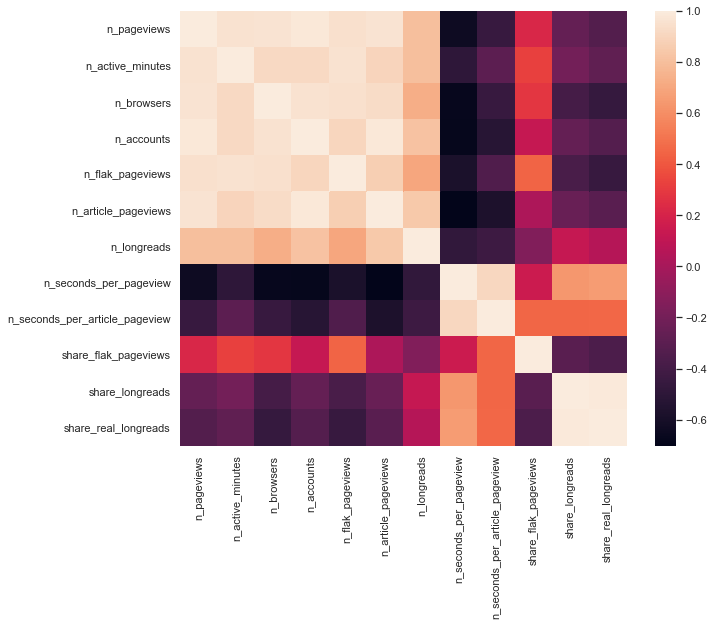

In [139]:
# Here we can see which KPIs correlate with each other - which helps us create insightful heatmaps
sns.set(rc={'figure.figsize':(10,8)})

sns.heatmap(df_reading[[
    'n_pageviews', 'n_active_minutes', 'n_browsers', 'n_accounts', 'n_flak_pageviews', 
    'n_article_pageviews', 'n_longreads', 'n_seconds_per_pageview', 'n_seconds_per_article_pageview',
    'share_flak_pageviews', 'share_longreads', 'share_real_longreads'
]].corr(method='spearman')); # spearman = rankkorrelation = nice på skev data

plt.savefig(f'kpi_correlation_table.png', bbox_inches = "tight")

## 2.2 ARTICLE PUBLICATIONS AND PURCHASES

#### We do not filter for outliers here, in the same way that is done for consumer metrics. This is because publishing and purchasing is less variable.

In [10]:
def posting_query_text(from_date, to_date):

    query = f'''

                SELECT 
                  s.name AS section,
                  EXTRACT(DAYOFWEEK FROM publication_time AT TIME ZONE "Europe/Stockholm") AS weekday, # TEST REMOVE/ADD: AT TIME ZONE "Europe/Stockholm"
                  EXTRACT(HOUR FROM publication_time AT TIME ZONE "Europe/Stockholm") AS hour,
                  COUNT(DISTINCT art.identifier.id) AS n_publications,
                  #COUNT(DISTINCT pur.id) AS n_purchases 
                FROM `data-warehouse-dn.content.article` art,
                UNNEST(sections) s
                #LEFT JOIN `bn-analytics.orders.order_latest_norm` pur
                  #ON pur.article_id = art.identifier.id
                WHERE 1=1
                  AND art.publication_time BETWEEN "{from_date}" AND "{to_date}"
                  #AND pur.created_utc BETWEEN "{from_date}" AND "{to_date}" # Dates for when the purchases occured.
                  #AND DATE(created_sthlm_tz) BETWEEN "{from_date}" AND "{to_date}" # Dates for when the purchases occured.
                  AND s.name IN {SECTIONS}
                  #AND state = 'FULFILLED'
                  #AND flowtype IN ('PAYWALL','API')
                  #AND LOWER(payment_method) != 'trial'
                  #AND LOWER(payment_method) != 'prepaid'
                  #AND article_id NOT IN ('0', '')
                GROUP BY 1,2,3

            '''
    
    return(query)

In [11]:
df_posting = (
    pd.read_gbq(posting_query_text(from_date=FROM_DATE, to_date=TO_DATE), project_id=PROJECT)
)

df_posting_comp = (
    pd.read_gbq(posting_query_text(from_date=FROM_DATE_COMP, to_date=TO_DATE_COMP), project_id=PROJECT)
)

# Fix weekdays from numbers to words.
transform_weekday(data=df_posting)
transform_weekday(data=df_posting_comp)

# Normalise values based on # of weeks.
df_posting[['n_publications']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_posting[['n_publications']])
df_posting_comp[['n_publications']] = normalise_weeks(from_date=FROM_DATE, to_date=TO_DATE, data=df_posting_comp[['n_publications']])

Downloading: 100%|██████████| 1154/1154 [00:00<00:00, 2954.56rows/s]


# 3. VISUALISE: HEATMAPS

#### The heatmaps function has a input variable "comp_data" referring to a comparable dataset. If you add a dataset to this variable, you can compare changes over time.

## 3.1 READING (PAGEVIEWS, MINUTES SPENT, USERS)

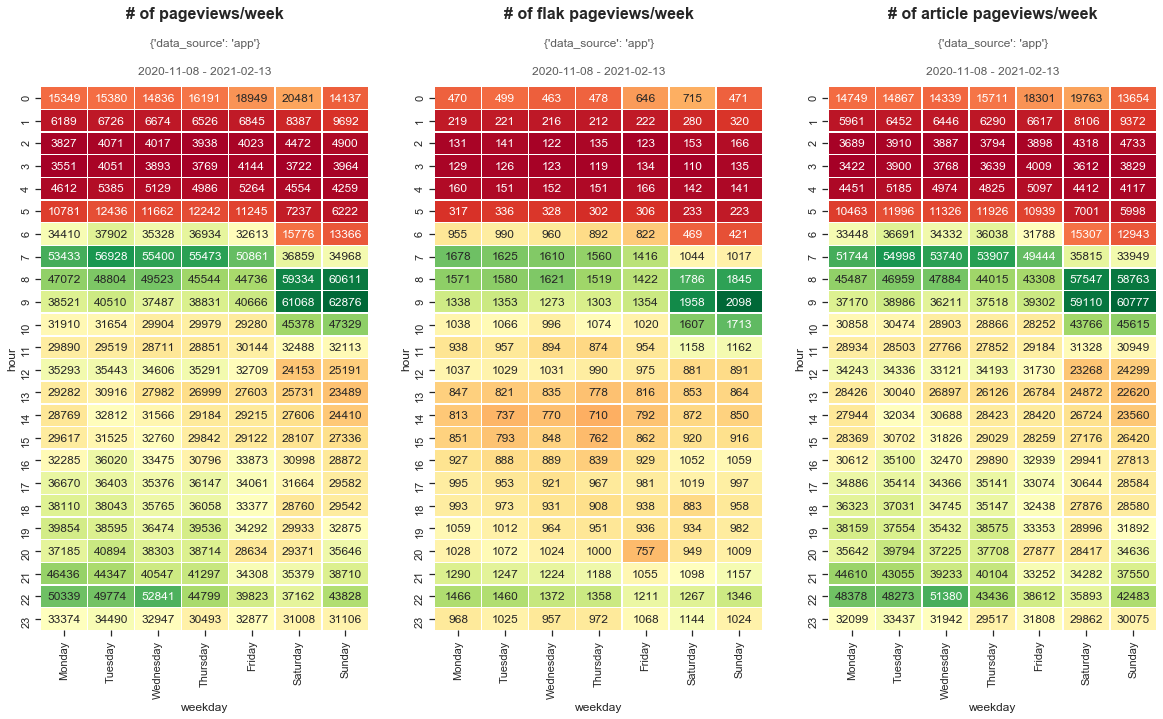

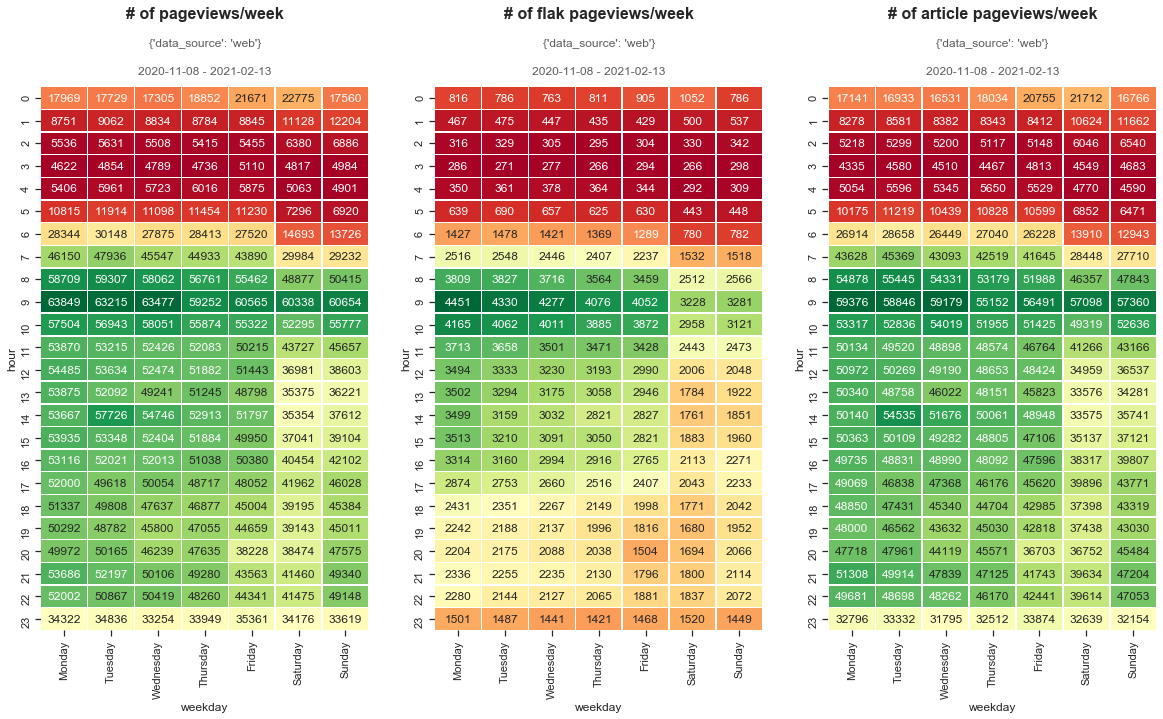

In [354]:
# Maximum three metrics!
metrics = {
    'n_pageviews': '# of pageviews/week',
    'n_flak_pageviews': '# of flak pageviews/week', 
    'n_article_pageviews': '# of article pageviews/week', 
}

# Select which sections to examine.
grouping_list = df_reading[f'{GROUPING}'].unique()

for val in grouping_list:
    
    # Select filtering parameters
    params = {
        f'{GROUPING}': f'{val}',
        #'section': 'Halla' # ONLY INCLUDE IF YOU WANT TO HIGHLIGHT CERTAIN SECTION
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_reading, 
            metrics=metrics,
            dates=dates); # add comp_data=df_reading_comp  # agg_methods=agg_methods,
    
    #plt.savefig(f'{FROM_DATE}_pageviews_{TO_DATE}_{params}.png')
    #plt.savefig(f'{FROM_DATE}_pageviewscomp_{TO_DATE}_{params}.png')

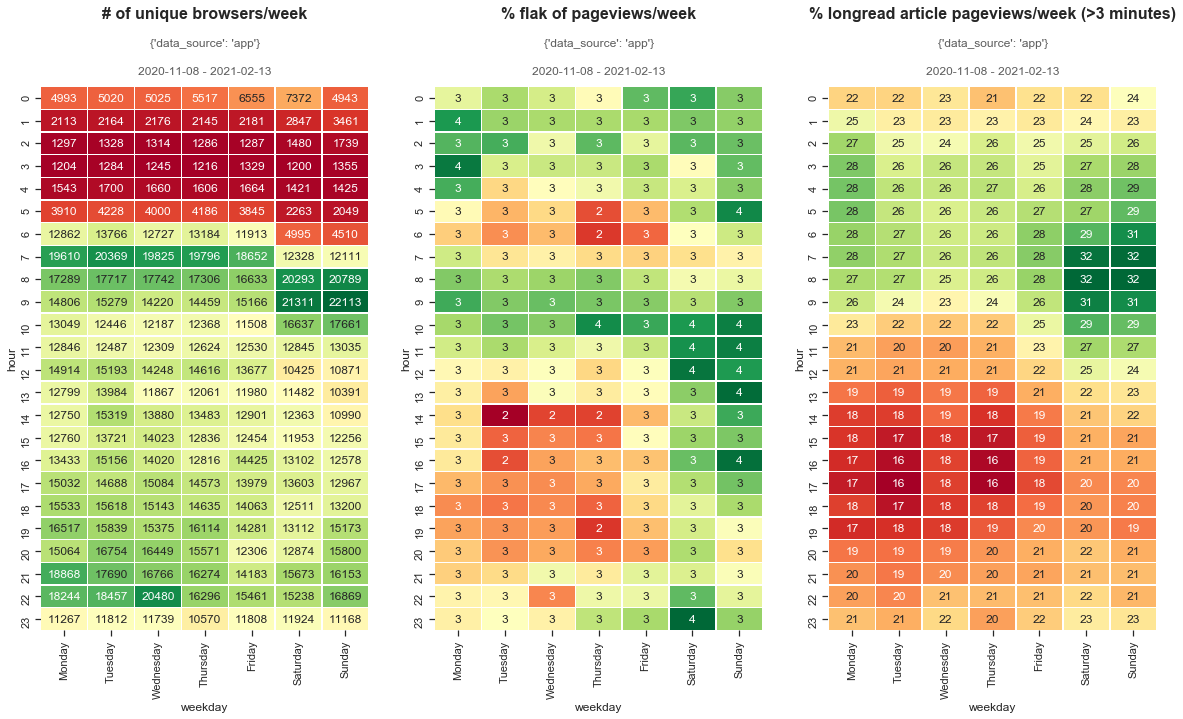

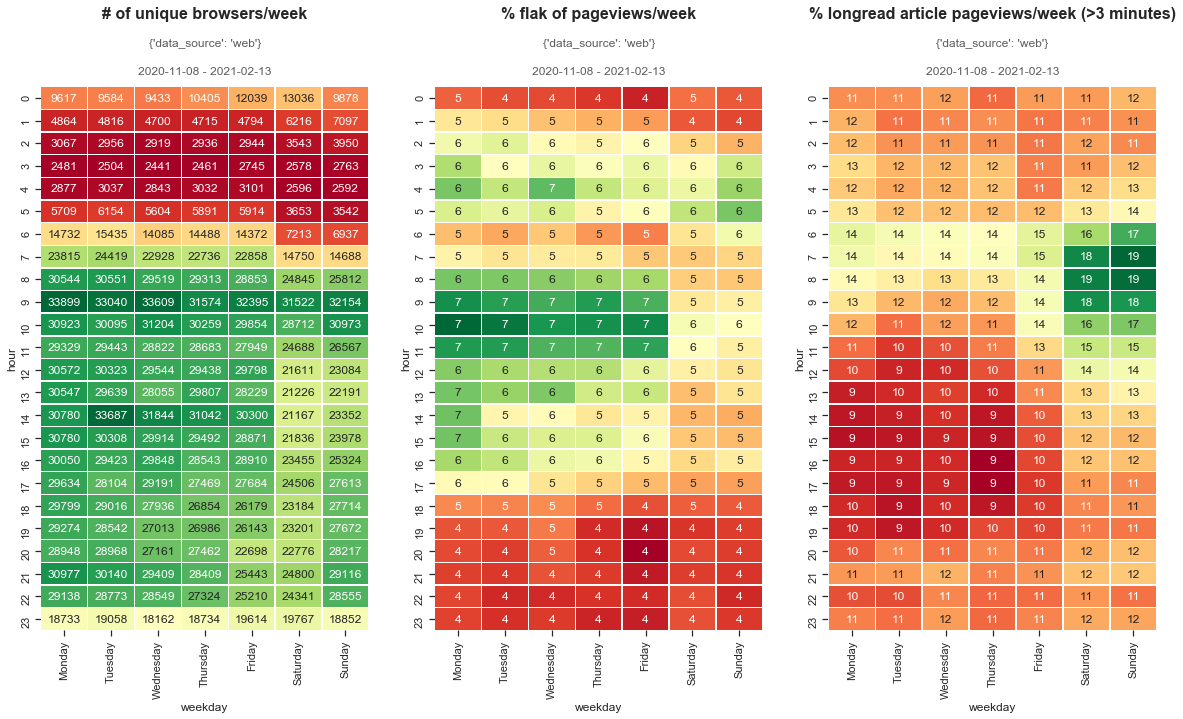

In [356]:
# Maximum three metrics!
metrics = {
    'n_browsers': '# of unique browsers/week',
    'share_flak_pageviews': '% flak of pageviews/week',
    'share_real_longreads': '% longread article pageviews/week (>3 minutes)'
}

# Select which sections to examine.
grouping_list = df_reading[f'{GROUPING}'].unique()

for val in grouping_list:
    
    # Select filtering parameters
    params = {
        f'{GROUPING}': f'{val}',
        #'section': 'Kultur' # ONLY INCLUDE IF YOU WANT TO HIGHLIGHT CERTAIN SECTION
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_reading, 
            metrics=metrics,
            dates=dates); # add comp_data=df_reading_comp 

    #plt.savefig(f'{FROM_DATE}_engagement_{TO_DATE}_{params}.png')
    #plt.savefig(f'{FROM_DATE}_engagementcomp_{TO_DATE}_{params}.png')

## 3.2 ARTICLE PUBLICATIONS

In [111]:
df_posting_all = df_posting.groupby(['weekday', 'hour']).aggregate({'n_publications':'sum'}).reset_index()
df_posting_all_comp = df_posting_comp.groupby(['weekday', 'hour']).aggregate({'n_publications':'sum'}).reset_index()

Error: Only 0 weekdays are represented in the dataset.
Error: Only 0 weekdays are represented in the dataset.


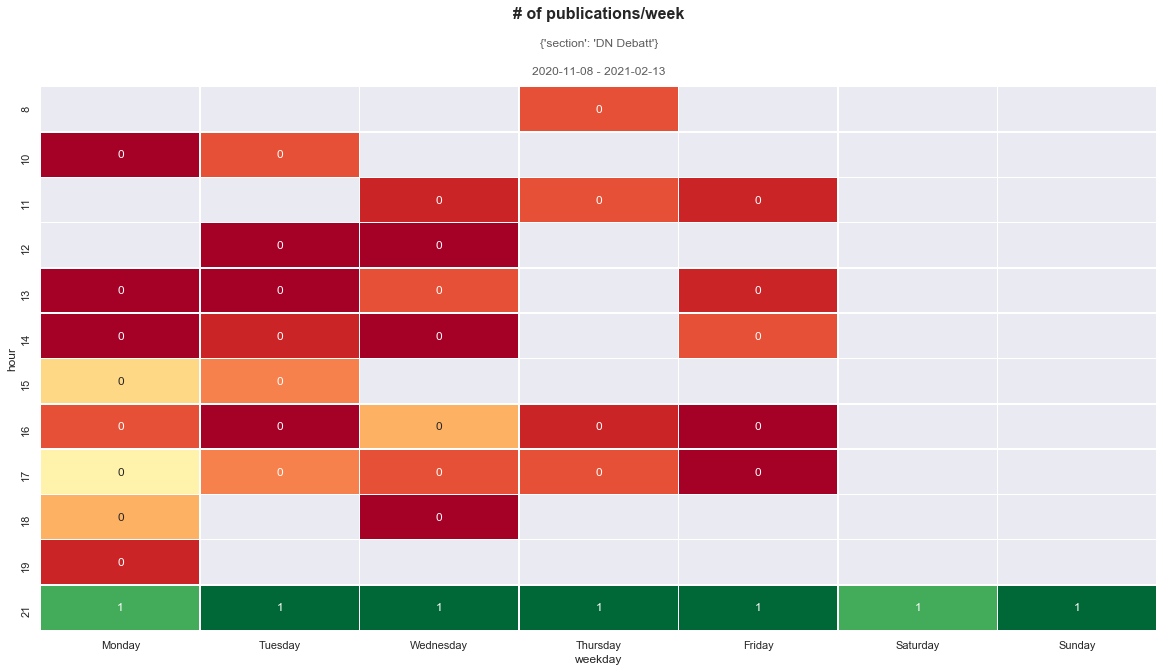

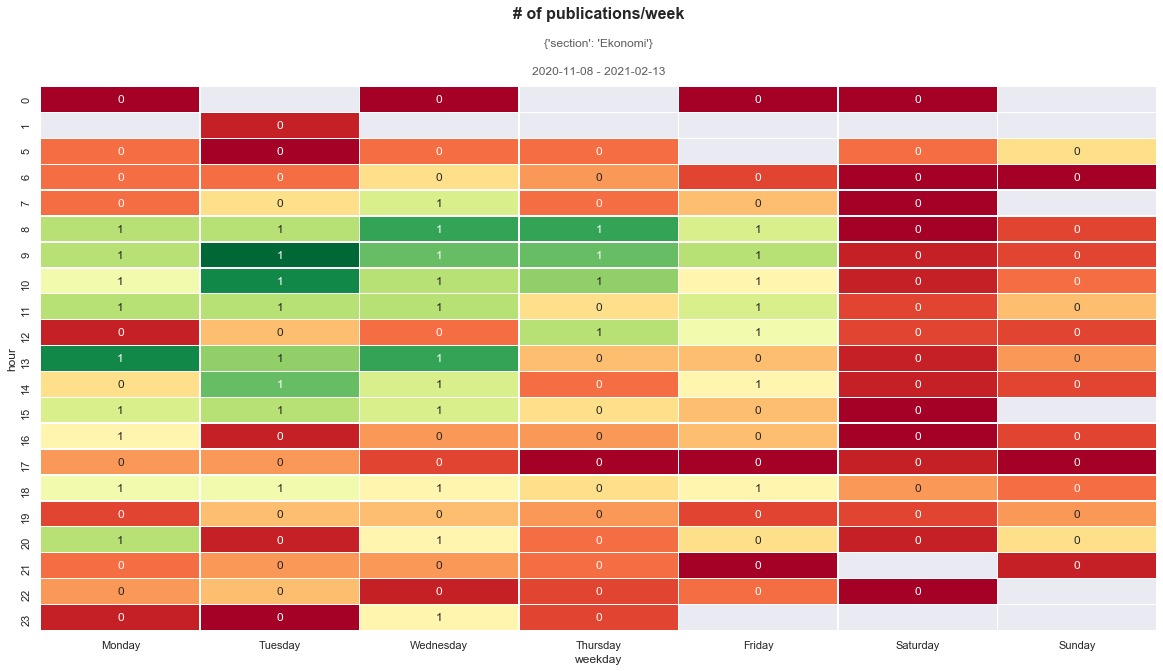

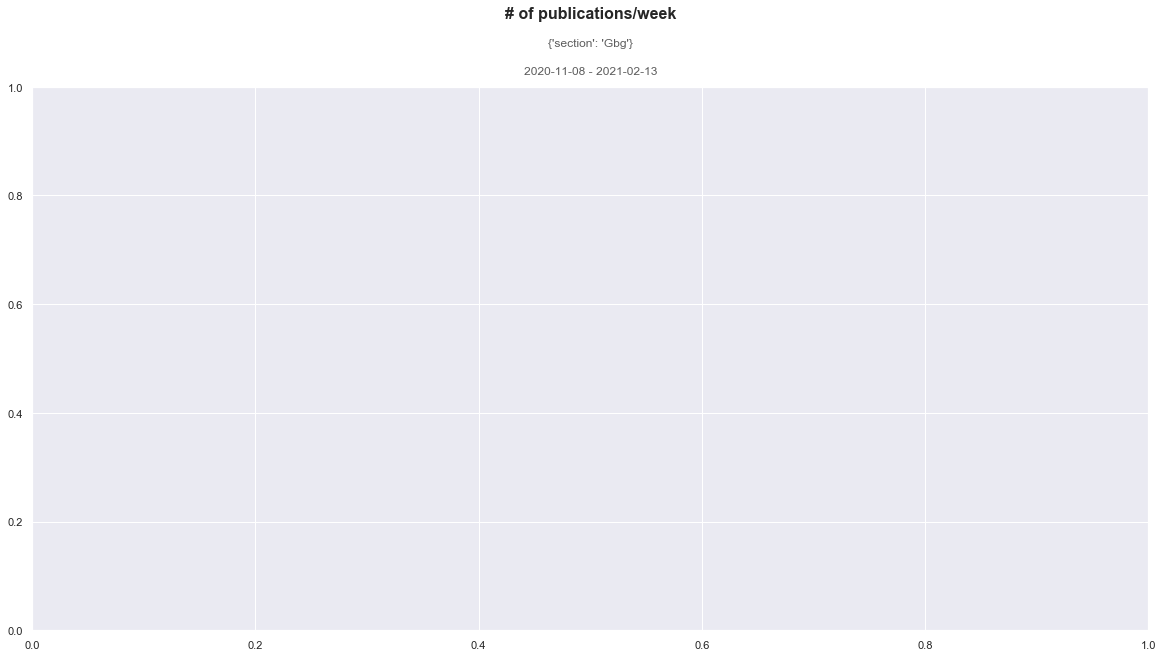

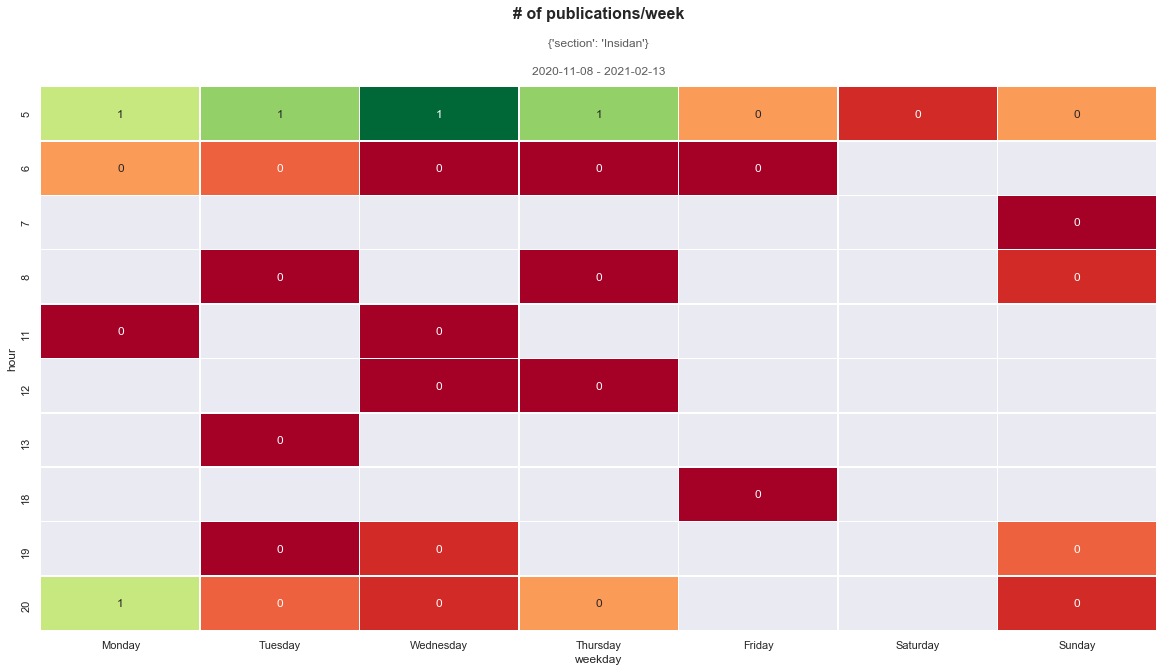

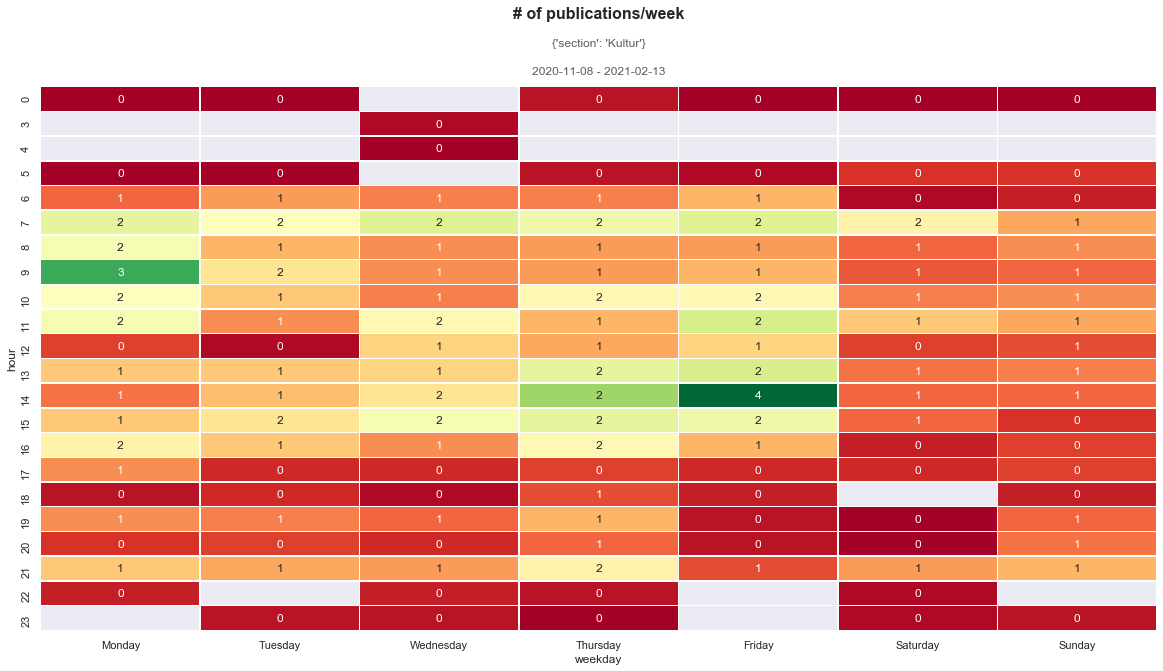

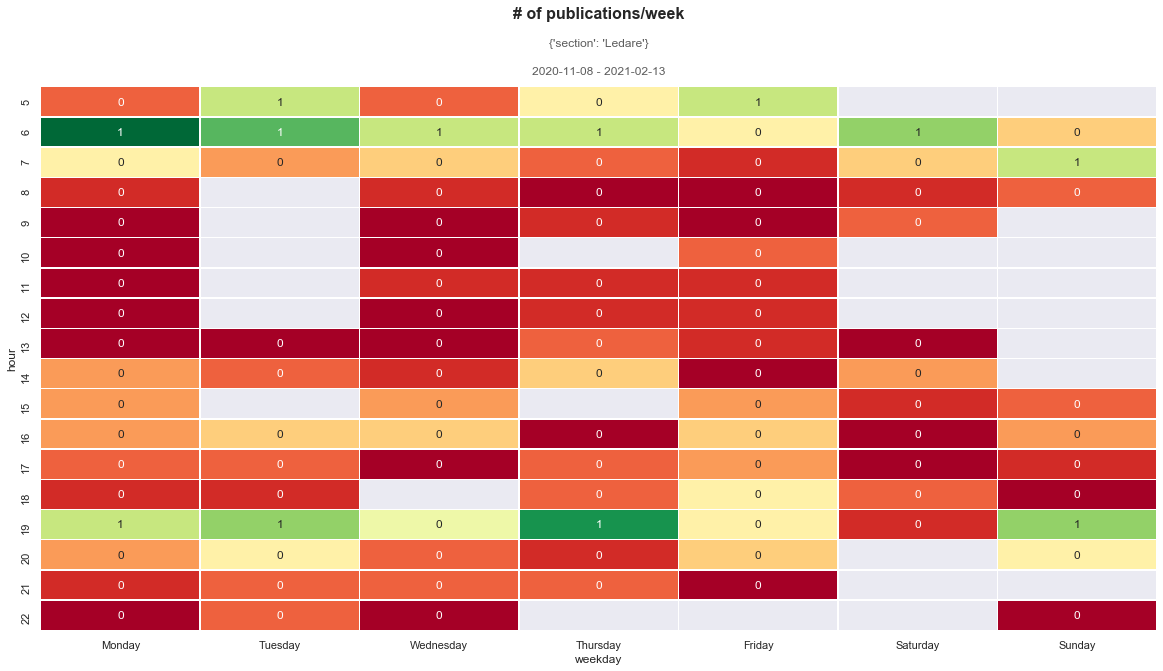

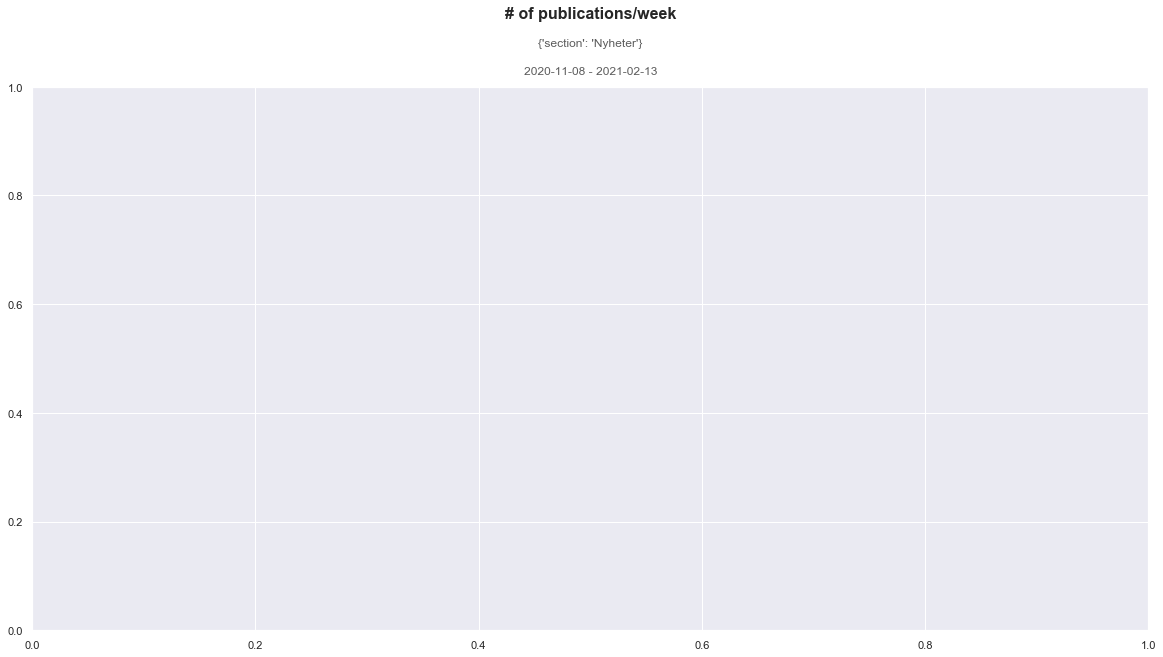

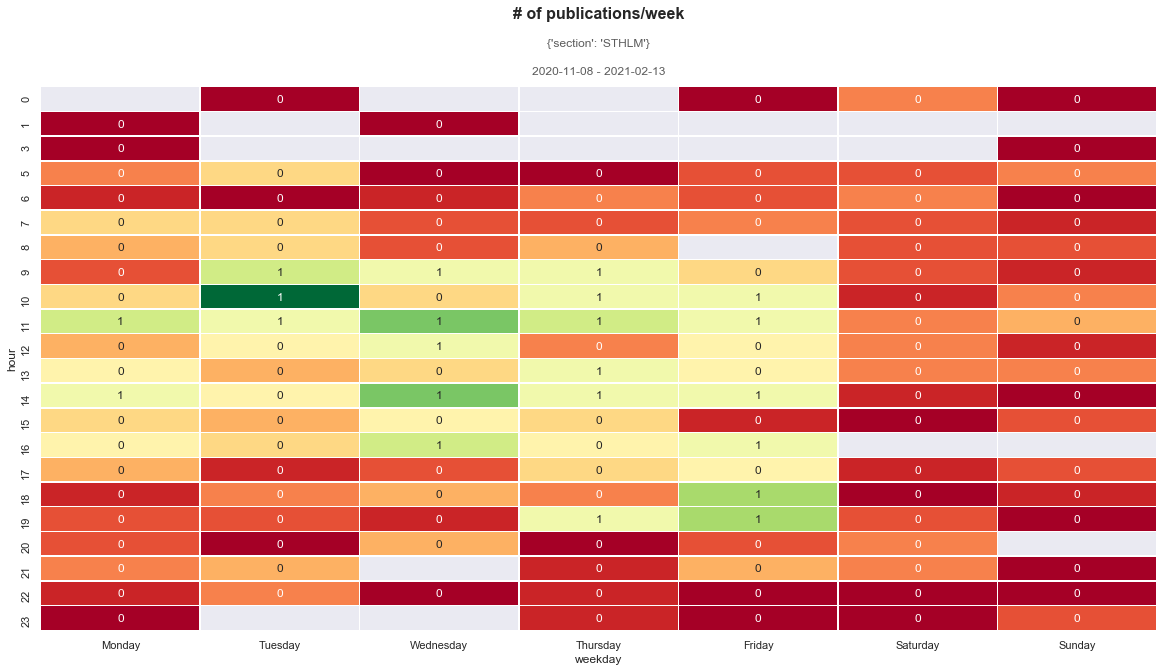

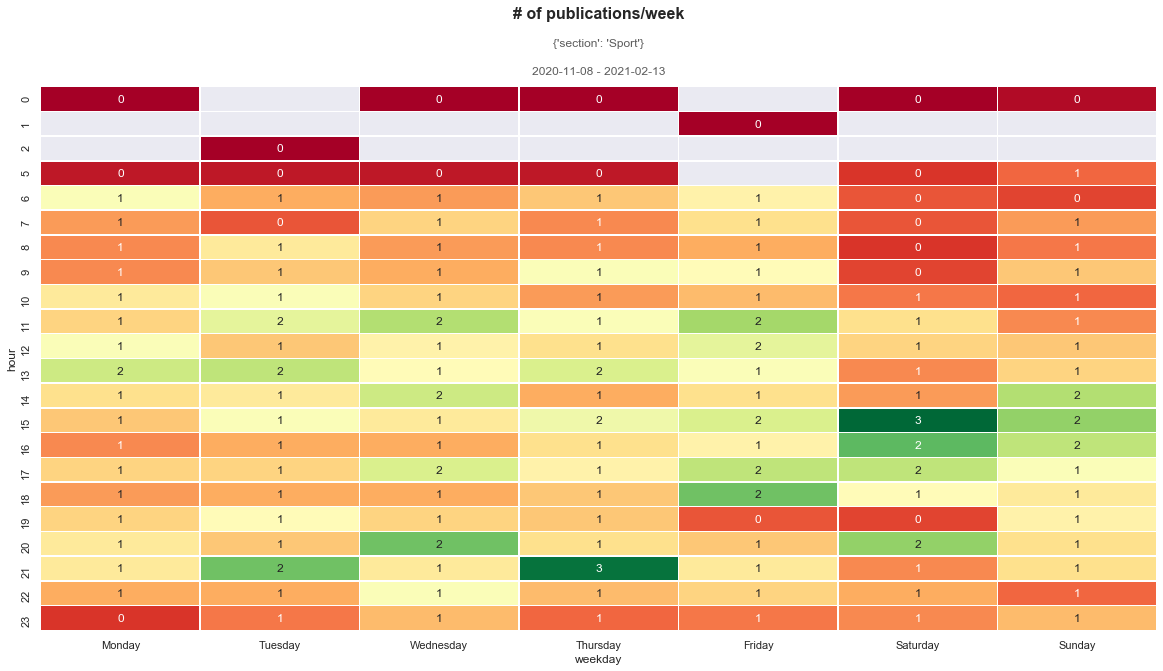

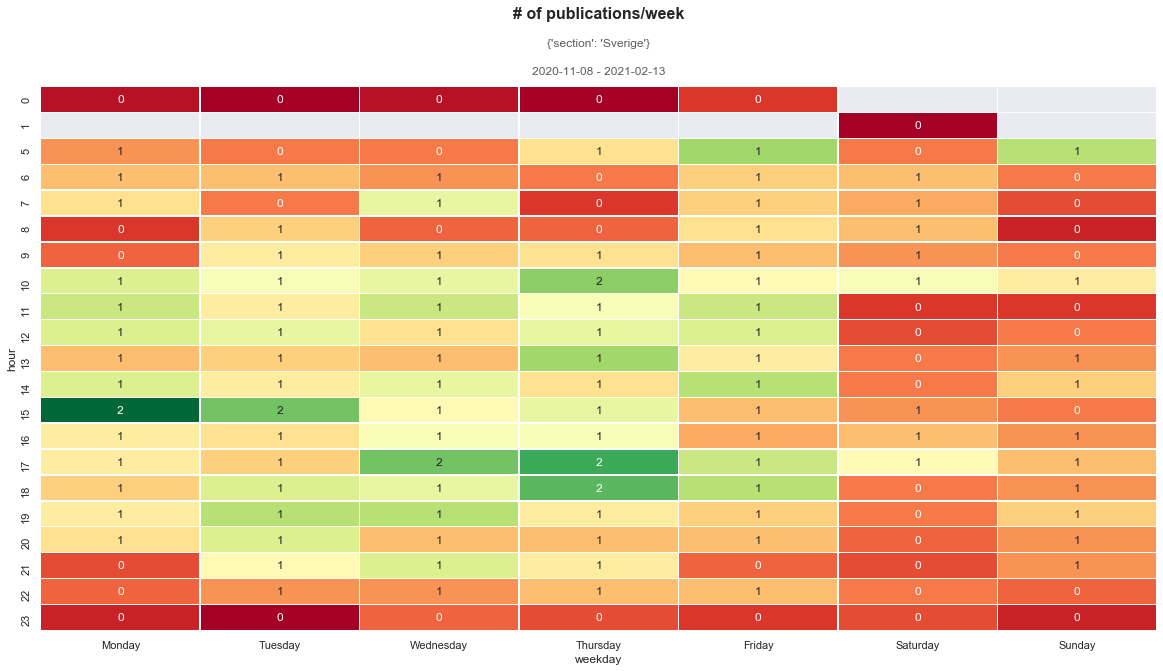

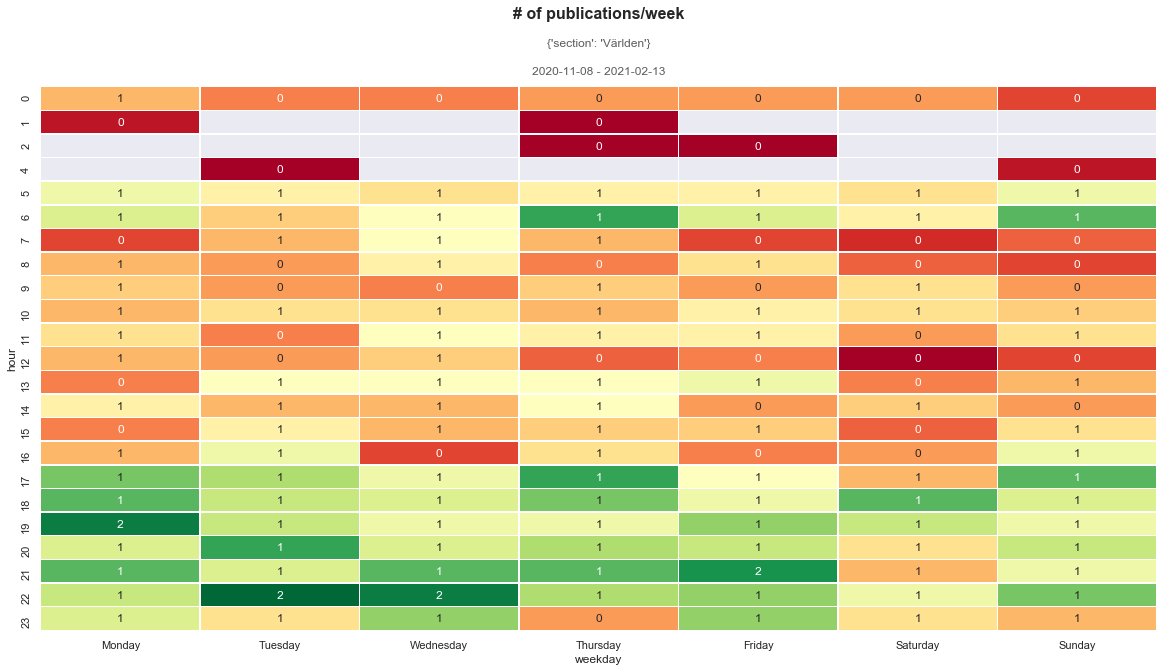

In [124]:
# Maximum three metrics!
metrics = {
    'n_publications': '# of publications/week',
    #'n_purchases': '# of purchases/week'
}

# Select which sections to examine.
grouping_list = df_reading[f'{GROUPING}'].unique()

for val in grouping_list:
    
    # Select filtering parameters
    params = {
        'section': f'{val}'
    }

    # Visualise behavioural heatmaps
    heatmap(params=params, 
            data=df_posting, 
            metrics=metrics,
            dates=dates); # add comp_data=df_posting_comp 

    plt.savefig(f'{FROM_DATE}_posting_{TO_DATE}_{params}.png')
    #plt.savefig(f'{FROM_DATE}_postingcomp_{TO_DATE}_{params}.png')
    
    try: # If we insert no grouping parameter, don't loop unnecessarily. 
        params['section']
    except:
        break

# WIP

In [153]:
df

,weekday,hour,Total,n_pageviews,n_flak_pageviews,n_article_pageviews,n_real_article_pageviews,n_longreads,n_active_minutes,n_active_article_minutes,n_browsers,n_accounts,share_flak_pageviews,share_longreads,share_real_longreads,n_seconds_per_pageview,n_seconds_per_article_pageview
0,1,0,Total,43911.571429,13329.785714,30557.285714,21161.214286,3938.214286,16130.885714,11162.007143,17750.785714,9755.285714,30.355975,12.887972,18.610531,22.040959,21.916882
1,1,1,Total,30659.214286,9536.571429,21111.428571,14487.142857,2576.357143,11834.550000,8048.164286,12674.785714,6825.357143,31.105074,12.203613,17.783749,23.160183,22.873386
2,1,2,Total,16954.357143,5628.928571,11318.142857,7705.285714,1451.285714,7247.550000,4771.092857,6971.857143,3521.857143,33.200484,12.822649,18.834937,25.648451,25.292628
3,1,3,Total,12968.285714,4413.428571,8550.285714,5991.071429,1229.000000,5963.800000,3815.992857,5102.785714,2654.714286,34.032475,14.373789,20.513860,27.592544,26.778002
4,1,4,Total,13270.000000,4523.000000,8744.571429,6356.857143,1374.142857,6368.585714,4020.621429,4973.785714,2692.857143,34.084401,15.714239,21.616702,28.795414,27.587091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,7,19,Total,97541.142857,30845.857143,66641.571429,47083.142857,7376.285714,32437.942857,23595.085714,44107.428571,24456.714286,31.623432,11.068595,15.666511,19.953391,21.243574
164,7,20,Total,96510.714286,31089.785714,65368.428571,46181.714286,7769.857143,32811.492857,23678.892857,43476.642857,24013.214286,32.213818,11.886254,16.824532,20.398663,21.734247
165,7,21,Total,107490.642857,33306.214286,74136.214286,52837.714286,9052.071429,34837.528571,25271.114286,48611.714286,27402.928571,30.985222,12.210054,17.131838,19.445895,20.452445
166,7,22,Total,109605.071429,33822.000000,75736.500000,52305.285714,9224.071429,32416.100000,22160.557143,47423.714286,27359.142857,30.858061,12.179163,17.635066,17.745219,17.556045


In [317]:
df_reading

,weekday,hour,section,n_pageviews,n_flak_pageviews,n_article_pageviews,n_real_article_pageviews,n_longreads,n_active_minutes,n_active_article_minutes,n_browsers,n_accounts,share_flak_pageviews,share_longreads,share_real_longreads,n_seconds_per_pageview,n_seconds_per_article_pageview
0,Friday,0,DN Debatt,1615.642857,81.000000,1534.642857,1016.785714,267.357143,876.500000,853.721429,1388.571429,693.071429,5.013484,17.421457,26.294345,32.550511,33.377985
1,Friday,0,Ekonomi,3536.750000,233.583333,3296.583333,2276.250000,418.916667,1411.075000,1320.541667,2666.416667,1827.416667,6.604463,12.707601,18.403807,23.938503,24.034733
2,Friday,0,Gbg,39.384615,39.384615,0.000000,0.000000,0.000000,15.069231,NaN,28.230769,23.000000,100.000000,NaN,NaN,22.957031,NaN
3,Friday,0,Insidan,375.307692,10.153846,365.153846,240.923077,89.230769,226.923077,224.223077,296.923077,202.846154,2.705472,24.436486,37.037037,36.277926,36.843059
4,Friday,0,Kultur,4854.000000,440.769231,4407.692308,2963.230769,566.769231,1958.546154,1842.907692,3140.307692,2160.076923,9.080536,12.858639,19.126733,24.209470,25.086702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,Wednesday,23,Ledare,2264.769231,185.000000,2079.769231,1433.846154,251.769231,949.115385,906.400000,1793.923077,1325.461538,8.168603,12.105633,17.559013,25.144691,26.149055
1676,Wednesday,23,STHLM,3903.307692,275.461538,3627.307692,2345.846154,412.230769,1506.476923,1421.192308,3014.615385,1852.153846,7.057131,11.364648,17.572796,23.156928,23.508218
1677,Wednesday,23,Sport,5032.500000,349.714286,4682.428571,3174.285714,231.785714,1326.957143,1234.000000,3392.642857,2590.714286,6.949116,4.950117,7.301980,15.820651,15.812307
1678,Wednesday,23,Sverige,17157.785714,162.571429,16995.214286,12182.214286,1806.642857,6262.950000,6200.385714,11388.428571,8070.857143,0.947508,10.630303,14.830168,21.901253,21.889877


In [329]:
test = pd.merge(df_reading, df, how='left', on=['weekday', 'hour'], suffixes=('_section','_total'))
test['share_article_pageviews'] = test.n_article_pageviews_section / test.n_article_pageviews_total
test['share_total_longreads'] = test.n_longreads_section / test.n_longreads_total
test.head(1)

,weekday,hour,section_section,n_pageviews_section,n_flak_pageviews_section,n_article_pageviews_section,n_real_article_pageviews_section,n_longreads_section,n_active_minutes_section,n_active_article_minutes_section,...,n_active_article_minutes_total,n_browsers_total,n_accounts_total,share_flak_pageviews_total,share_longreads_total,share_real_longreads_total,n_seconds_per_pageview_total,n_seconds_per_article_pageview_total,share_article_pageviews,share_total_longreads
0,Friday,0,DN Debatt,1615.642857,81.0,1534.642857,1016.785714,267.357143,876.5,853.721429,...,12704.746154,21563.076923,12410.769231,29.194373,12.500951,17.923155,20.6257,19.840594,0.039943,0.055666


In [330]:
params = {'section_section':'Kultur'}

filtered_data = filter_params(data=test, params=params)

filtered_data = standard_pivot(data=filtered_data, value='share_article_pageviews')

filtered_data

weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
0,0.136469,0.120655,0.117983,0.128369,0.114723,0.121306,0.121968
1,0.122853,0.140650,0.118651,0.120179,0.157520,0.114255,0.113469
2,0.119666,0.137087,0.119101,0.125881,0.149595,0.105147,0.113951
3,0.118255,0.130163,0.116844,0.128615,0.141808,0.103184,0.112469
4,0.112223,0.138809,0.116998,0.123352,0.130780,0.102086,0.114512
5,0.100329,0.122765,0.101170,0.106745,0.115145,0.104592,0.124903
6,0.086345,0.106742,0.096533,0.097706,0.116911,0.109323,0.135298
7,0.103615,0.143821,0.112826,0.120200,0.144303,0.139183,0.128827
8,0.133968,0.166530,0.131212,0.137685,0.147567,0.165937,0.150515


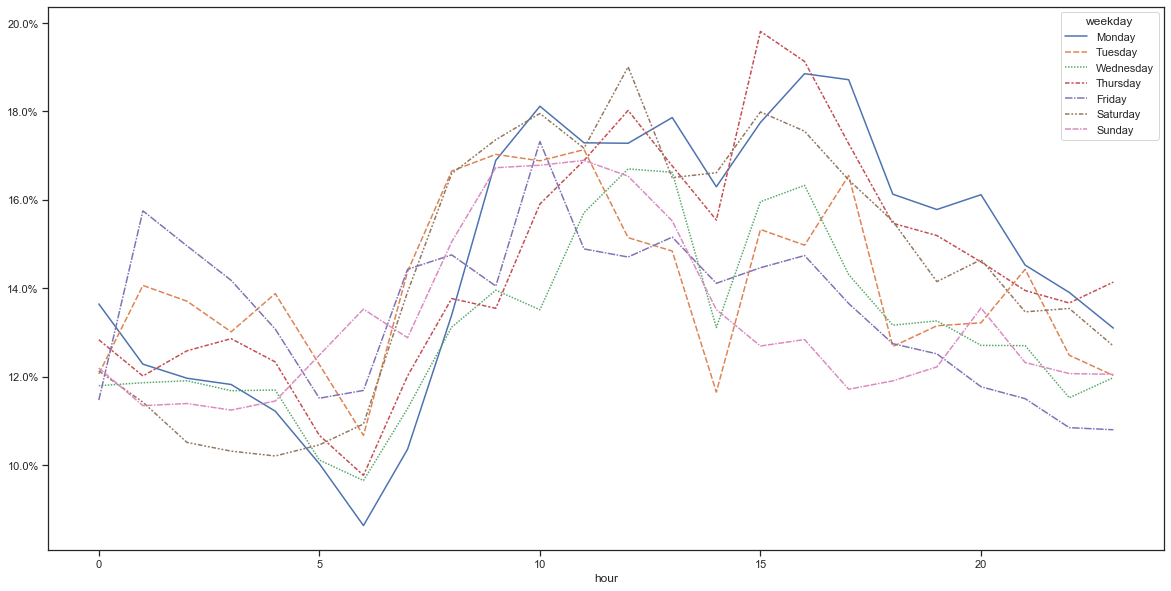

In [326]:
import matplotlib.ticker as mtick

sns.set(rc={'figure.figsize':(20,10)})

sns.set_style("ticks")

f, ax = plt.subplots()

sns.lineplot(data=filtered_data);

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [332]:
df = df.rename(columns={'Total': 'section'})

In [333]:
test = pd.concat([df_reading, df])
test

,weekday,hour,section,n_pageviews,n_flak_pageviews,n_article_pageviews,n_real_article_pageviews,n_longreads,n_active_minutes,n_active_article_minutes,n_browsers,n_accounts,share_flak_pageviews,share_longreads,share_real_longreads,n_seconds_per_pageview,n_seconds_per_article_pageview
0,Friday,0,DN Debatt,1615.642857,81.000000,1534.642857,1016.785714,267.357143,876.500000,853.721429,1388.571429,693.071429,5.013484,17.421457,26.294345,32.550511,33.377985
1,Friday,0,Ekonomi,3536.750000,233.583333,3296.583333,2276.250000,418.916667,1411.075000,1320.541667,2666.416667,1827.416667,6.604463,12.707601,18.403807,23.938503,24.034733
2,Friday,0,Gbg,39.384615,39.384615,0.000000,0.000000,0.000000,15.069231,NaN,28.230769,23.000000,100.000000,NaN,NaN,22.957031,NaN
3,Friday,0,Insidan,375.307692,10.153846,365.153846,240.923077,89.230769,226.923077,224.223077,296.923077,202.846154,2.705472,24.436486,37.037037,36.277926,36.843059
4,Friday,0,Kultur,4854.000000,440.769231,4407.692308,2963.230769,566.769231,1958.546154,1842.907692,3140.307692,2160.076923,9.080536,12.858639,19.126733,24.209470,25.086702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,Saturday,19,Total,97541.142857,30845.857143,66641.571429,47083.142857,7376.285714,32437.942857,23595.085714,44107.428571,24456.714286,31.623432,11.068595,15.666511,19.953391,21.243574
164,Saturday,20,Total,96510.714286,31089.785714,65368.428571,46181.714286,7769.857143,32811.492857,23678.892857,43476.642857,24013.214286,32.213818,11.886254,16.824532,20.398663,21.734247
165,Saturday,21,Total,107490.642857,33306.214286,74136.214286,52837.714286,9052.071429,34837.528571,25271.114286,48611.714286,27402.928571,30.985222,12.210054,17.131838,19.445895,20.452445
166,Saturday,22,Total,109605.071429,33822.000000,75736.500000,52305.285714,9224.071429,32416.100000,22160.557143,47423.714286,27359.142857,30.858061,12.179163,17.635066,17.745219,17.556045


In [340]:
filtered_data = (
    test.copy()
    .query('weekday.str.contains("Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday") & section.str.contains("Kultur|Ekonomi")', engine='python')
    .groupby(['hour', 'section'])
    .aggregate({'n_article_pageviews':'sum'})
    .reset_index()
)
    
filtered_data

,hour,section,n_article_pageviews
0,0,Ekonomi,16742.528388
1,0,Kultur,29392.796703
2,1,Ekonomi,8158.923077
3,1,Kultur,14260.120879
4,2,Ekonomi,5009.928571
5,2,Kultur,8324.428571
6,3,Ekonomi,4448.434066
7,3,Kultur,7065.736264
8,4,Ekonomi,5225.802198
9,4,Kultur,8383.456044


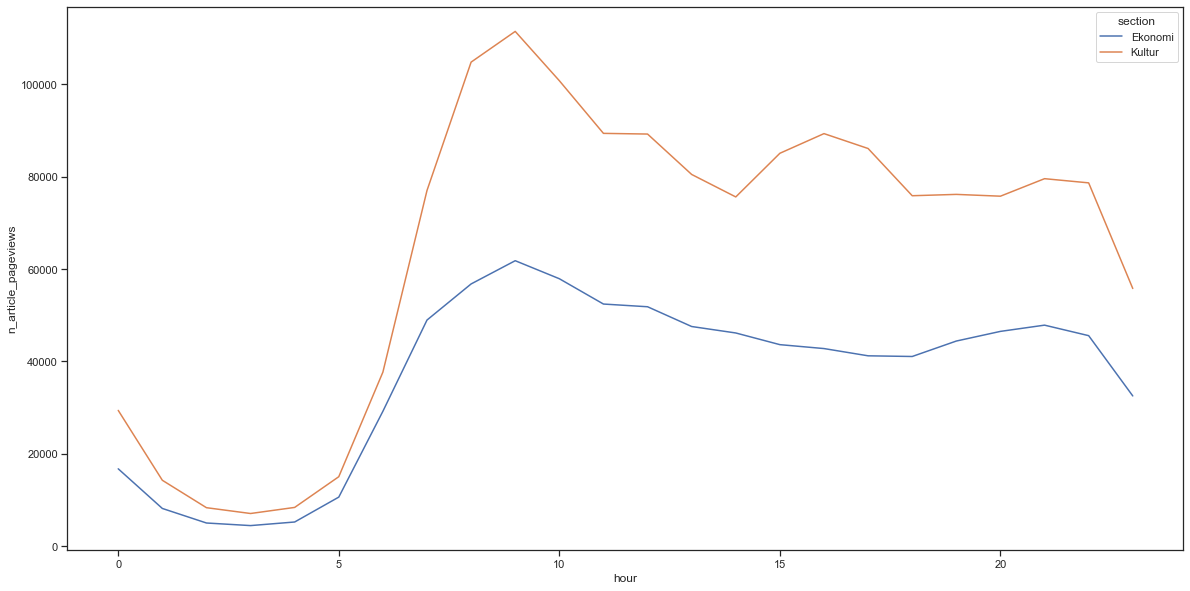

In [341]:
sns.set(rc={'figure.figsize':(20,10)})

sns.set_style("ticks")

#f, ax = plt.subplots()

sns.lineplot(data=filtered_data, x='hour', y='n_article_pageviews', hue='section');

#ax.yaxis.set_major_formatter(mtick.PercentFormatter()) # Add 1.0 to fix

In [307]:
filtered_data = (
    test.copy()
    .query('section.str.contains("Världen|Sverige")', engine='python')
)

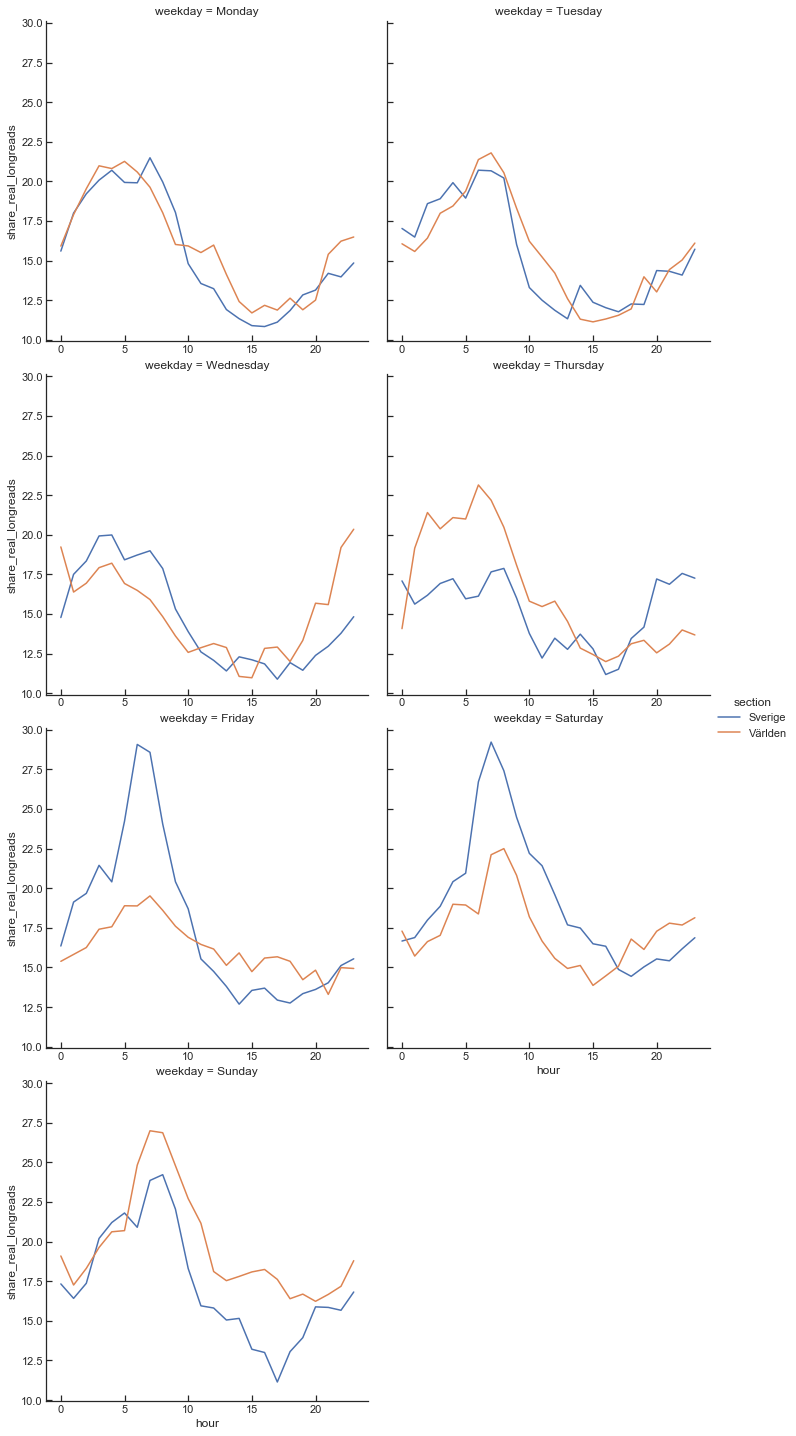

In [310]:
filtered_data['weekday'] = pd.Categorical(filtered_data['weekday'], ["Monday", 
                                                                     "Tuesday", 
                                                                     "Wednesday", 
                                                                     "Thursday", 
                                                                     "Friday", 
                                                                     "Saturday", 
                                                                     "Sunday"])

g = sns.relplot(
    data=filtered_data, x="hour", y="share_real_longreads",
    col="weekday", hue="section", kind="line", col_wrap=2
)

for ax in g.axes.flatten():
    ax.tick_params(direction='in', labelbottom=True)